In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import argparse
import os
import random
from tqdm import tqdm
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import utils
import numpy as np

plt.rcParams['figure.figsize'] = (20, 5)

In [3]:
class parameter:
    def __init__(self):
        self.batch_size = 64
        self.n_past = 5
        self.n_future = 20
        self.num_threads = 16
        self.data_root = '../data_uni'
        self.model_path = './logs/0407_content_disc_w_loss_c/'
        self.seed = 1
        self.nsample = 100
        self.N = 256

In [4]:
opt = parameter()

In [5]:
opt.log_dir = os.path.join(opt.model_path, 'plots')
opt.model_path = os.path.join(opt.model_path, 'model.pth')
os.makedirs('%s' % opt.log_dir, exist_ok=True)

opt.n_eval = opt.n_past+opt.n_future
opt.max_step = opt.n_eval

print("Random Seed: ", opt.seed)
random.seed(opt.seed)
torch.manual_seed(opt.seed)
torch.cuda.manual_seed_all(opt.seed)
dtype = torch.cuda.FloatTensor

Random Seed:  1


In [6]:
tmp = torch.load(opt.model_path)
encoder_lstm = tmp['encoder_lstm']
decoder_lstm = tmp['decoder_lstm']
content_lstm = tmp['content_lstm']
encoder_c = tmp['encoder_c']
encoder_p = tmp['encoder_p']
decoder = tmp['decoder']

encoder_lstm.eval()
decoder_lstm.eval()
content_lstm.eval()
encoder_c.eval()
encoder_p.eval()
decoder.eval()

encoder_lstm.batch_size = opt.batch_size
decoder_lstm.batch_size = opt.batch_size
content_lstm.batch_size = opt.batch_size
opt.g_dim = tmp['opt'].g_dim
opt.z_dim = tmp['opt'].z_dim
opt.num_digits = tmp['opt'].num_digits

In [7]:
# --------- transfer to gpu ------------------------------------
encoder_lstm.cuda()
decoder_lstm.cuda()
content_lstm.cuda()
encoder_c.cuda()
encoder_p.cuda()
decoder.cuda()

decoder(
  (upc1): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (upc2): dcgan_upconv(
    (main): Sequential(
      (0): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (upc3): dcgan_upconv(
    (main): Sequential(
      (0): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (upc4): dcgan_upconv(
    (main): Sequential(
      (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentu

In [8]:
# ---------------- set the options ----------------
opt.dataset = tmp['opt'].dataset
opt.last_frame_skip = tmp['opt'].last_frame_skip
opt.channels = tmp['opt'].channels
opt.image_width = tmp['opt'].image_width

print(opt)

In [9]:
_, test_data = utils.load_dataset(opt)

test_loader = DataLoader(test_data,
                         num_workers=16,
                         batch_size=64,
                         shuffle=True,
                         drop_last=True,
                         pin_memory=True)

/home/minyuan/anaconda3/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [10]:
def get_testing_batch():
    while True:
        for sequence in test_loader:
            batch = utils.normalize_data(opt, dtype, sequence)
            yield batch 
testing_batch_generator = get_testing_batch()

In [11]:
# Forward functions
## Forward function for generating global content vector
def forward_content_branch(x):
    """
    Input: training data
    Return: (vec_c_seq, vec_c_global, skip connection)
    """
    vec_c_seq = [encoder_c(x[i])[0] for i in range(len(x))]
    skip = encoder_c(x[-1])[1]
    vec_c_global = content_lstm(vec_c_seq, return_last=True)[0]
    return (vec_c_seq, vec_c_global, skip)

## Forward function for encoder part in pose branch
def forward_pose_encoder_branch(x, vec_c_global, detach=False, local_only=False):
    """
    Input: training datam global content vector
    Return: (vec_p_seq, vec_p_global, mu, logvar)
    """
    vec_p_seq = [encoder_p(x[i], vec_c_global)[0] for i in range(len(x))]
    
    if local_only:
        return vec_p_seq
    else:
        if detach:
            vec_p_seq_d = [vec_p.detach() for vec_p in vec_p_seq]
        else:
            vec_p_seq_d = vec_p_seq
        vec_p_global, mu, var = encoder_lstm(vec_p_seq_d)
        return (vec_p_seq, vec_p_global, mu, var)
    
## Forward function for decoder part in pose branch
def forward_pose_decoder_branch(vec_p_seq, vec_p_global):
    """
    Input: pose vector sequence, global pose vector
    Return: resonstructed pose vector sequence
    """
    vec_in_seq = []
    for i in range(len(vec_p_seq)):
        if i > 0:
            vec_in = vec_p_seq[i - 1]
        else:
            vec_in = torch.zeros_like(vec_p_seq[0])
        vec_in_seq.append(torch.cat([vec_p_global, vec_in], 1))
    vec_p_recon_seq = decoder_lstm(vec_in_seq)[0]
    return vec_p_recon_seq
    
## Forward function for decoder
def forward_decoder(vec_p_seq, vec_c_global, skip):
    """
    Input: pose vec sequence, global content vector, skip connection
    Return: list of predicted frames
    """
    x_pred_list = []
    for i in range(len(vec_p_seq)):
        vec_p = vec_p_seq[i]
        x_pred = decoder([torch.cat([vec_c_global, vec_p], 1), skip])
        x_pred_list.append(x_pred)
    return x_pred_list

In [12]:
x = next(testing_batch_generator)

In [13]:
with torch.no_grad():
    print(len(x))
    _, vec_c_global, skip = forward_content_branch(x[:opt.n_past])
    vec_p_seq, _, vec_p_global, _ = forward_pose_encoder_branch(x, vec_c_global)
    vec_p_recon_seq = forward_pose_decoder_branch(vec_p_seq, vec_p_global)
    x_pred_gt = forward_decoder(vec_p_seq, vec_c_global, skip)
    x_pred_recon = forward_decoder(vec_p_recon_seq, vec_c_global, skip)
print(vec_p_seq[1][0])
print(vec_p_recon_seq[1][0])
print(x_pred_gt[0].shape)
print(x_pred_recon[0].shape)

25
tensor([ 0.2579, -0.2064, -0.0249,  0.1305, -0.0190, -0.4017, -0.0341,  0.0147,
         0.0779,  0.7180,  0.0660, -0.6063,  0.2096,  0.3682,  0.0223,  0.0510,
         0.1880,  0.0899, -0.4673, -0.0807,  0.2279,  0.0022,  0.1822, -0.2183,
         0.2201, -0.0681, -0.2151, -0.2513, -0.1351,  0.0880, -0.0930, -0.0320,
         0.3220,  0.3125, -0.2072, -0.2586, -0.5130, -0.0990, -0.4053, -0.1829,
         0.2307, -0.0089,  0.2497, -0.1855,  0.0615, -0.0813, -0.0929, -0.0264,
        -0.4037, -0.1557, -0.2000,  0.2212,  0.1123,  0.3035,  0.2148,  0.3622,
         0.2734,  0.1632, -0.1392,  0.1360,  0.1592, -0.0392, -0.1421,  0.1687,
        -0.3474,  0.0578, -0.3156,  0.3317, -0.0211,  0.8692,  0.2031,  0.2414,
         0.7028, -0.1642, -0.0093, -0.0819, -0.2112, -0.1175, -0.0438,  0.0163,
         0.2669,  0.1640, -0.2358,  0.0492,  0.1002,  0.1373, -0.5771, -0.4434,
         0.4895,  0.0776,  0.0465,  0.0687,  0.3502, -0.6043,  0.1208, -0.5369,
         0.4650,  0.1124,  0.2020, -0

In [14]:
l2 = []
for p, p_recon in zip(vec_p_seq, vec_p_recon_seq):
    l2.append(F.mse_loss(p_recon, p).item())
l2

[0.020272552967071533,
 0.0032536694779992104,
 0.0021055552642792463,
 0.0019252176862210035,
 0.0017588926712051034,
 0.0016991409938782454,
 0.0015985697973519564,
 0.0015681975055485964,
 0.0014417285565286875,
 0.0013811171520501375,
 0.0013779173605144024,
 0.0014526206068694592,
 0.0014608018100261688,
 0.0016885489458218217,
 0.0018091173842549324,
 0.0016883134376257658,
 0.001624941942282021,
 0.0015745223499834538,
 0.0015636780299246311,
 0.0015325298300012946,
 0.0016312894877046347,
 0.0015867839101701975,
 0.0015659402124583721,
 0.0015597071032971144,
 0.0016328154597431421]

In [15]:
l2 = []
for pred, gt in zip(x_pred_gt, x):
    l2.append(F.mse_loss(pred, gt).item())
l2

[0.001933509949594736,
 0.0019812011159956455,
 0.0018777456134557724,
 0.001978357322514057,
 0.0012031642254441977,
 0.0019312261138111353,
 0.0018479354912415147,
 0.0019424577476456761,
 0.0019187488360330462,
 0.0019001464825123549,
 0.0018562291515991092,
 0.001962528098374605,
 0.0020693312399089336,
 0.002204315271228552,
 0.0022011036053299904,
 0.002259325236082077,
 0.0022032035049051046,
 0.002066558226943016,
 0.001933873863890767,
 0.0019027430098503828,
 0.0018516946583986282,
 0.001920715905725956,
 0.0019079118501394987,
 0.0018520569428801537,
 0.0020155515521764755]

In [16]:
l2 = []
for recon, gt in zip(x_pred_recon, x):
    l2.append(F.mse_loss(recon, gt).item())
l2

[0.033126212656497955,
 0.01121925376355648,
 0.0066077494993805885,
 0.005285751074552536,
 0.0036696349270641804,
 0.004739752970635891,
 0.004465451929718256,
 0.004494260530918837,
 0.004048438742756844,
 0.003710615448653698,
 0.003598172450438142,
 0.0038656918331980705,
 0.004016108810901642,
 0.0047189779579639435,
 0.005018001422286034,
 0.004912024829536676,
 0.004645917564630508,
 0.004164550453424454,
 0.004382972605526447,
 0.004079051315784454,
 0.004071725066751242,
 0.004336324520409107,
 0.0041815899312496185,
 0.004210439044982195,
 0.004445531405508518]

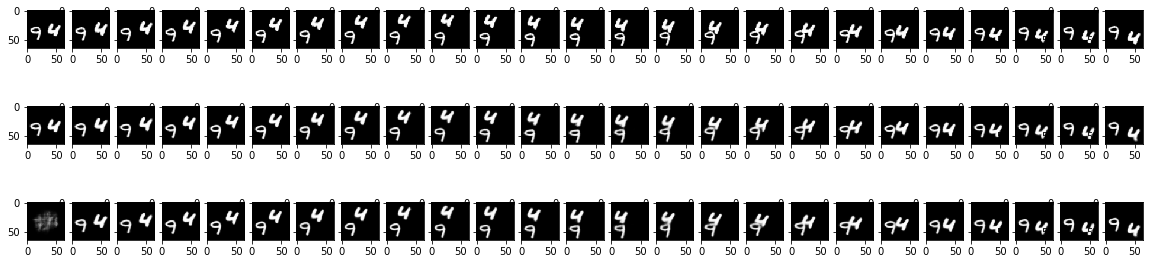

In [17]:
f, axs = plt.subplots(3, len(x))
for i in range(len(x)):
    img_gt = transforms.ToPILImage()(x[i][0].cpu())
    img_pred = transforms.ToPILImage()(x_pred_gt[i][0].cpu())
    img_recon = transforms.ToPILImage()(x_pred_recon[i][0].cpu())
    axs[0][i].imshow(img_gt)
    axs[1][i].imshow(img_pred)
    axs[2][i].imshow(img_recon)
f.savefig('visualization.jpg', dpi=300)

# influence of Z

In [18]:
vec_p_g_list = []
with torch.no_grad():
    for i in range(1, len(x) + 1):
        _, _, v_g, _ = forward_pose_encoder_branch(x[:i], vec_c_global)
        vec_p_g_list.append(v_g)
        
l2 = []
for v_g in vec_p_g_list:
    l2.append(F.mse_loss(v_g, vec_p_global).item())
l2

[0.00377055280841887,
 2.9004584575886838e-05,
 3.743628269603505e-07,
 1.5142448717142543e-07,
 1.5246232010213134e-07,
 1.4280459481597063e-07,
 1.319406663924383e-07,
 1.1917664721750043e-07,
 1.0595097421628452e-07,
 9.333794537269569e-08,
 8.13336100691231e-08,
 7.01090812071925e-08,
 5.978392181305026e-08,
 5.0262165984804597e-08,
 4.1519079729823716e-08,
 3.3641498475844855e-08,
 2.6505640349228088e-08,
 2.029970858075103e-08,
 1.4897493905152714e-08,
 1.0338469635939873e-08,
 6.6102785467592184e-09,
 3.718762631166328e-09,
 1.649190672914358e-09,
 4.270155895547134e-10,
 0.0]

In [19]:
with torch.no_grad():    
    vec_p_recon_seq_diffZ = forward_pose_decoder_branch(vec_p_seq, vec_p_g_list[0])
    vec_p_recon_seq_zeroZ = forward_pose_decoder_branch(vec_p_seq, torch.zeros_like(vec_p_global))
    x_pred_recon_diffZ = forward_decoder(vec_p_recon_seq_diffZ, vec_c_global, skip)
    x_pred_recon_zeroZ = forward_decoder(vec_p_recon_seq_zeroZ, vec_c_global, skip)

In [20]:
l2_diffZ = []
l2_zeroZ = []
for recon_diffZ, recon_zeroZ, recon in zip(x_pred_recon_diffZ, x_pred_recon_zeroZ, x_pred_recon):
    l2_diffZ.append(F.mse_loss(recon_diffZ, recon).item())
    l2_zeroZ.append(F.mse_loss(recon_zeroZ, recon).item())
l2_diffZ

[1.3577814428344936e-08,
 1.527391759736929e-07,
 1.0170235498208058e-07,
 6.470703795002919e-08,
 4.9023558545968626e-08,
 5.848795581187005e-08,
 5.8751048470639944e-08,
 6.581836942132213e-08,
 6.777673888791469e-08,
 5.561619076388524e-08,
 5.8974130467959185e-08,
 6.150541054239511e-08,
 6.088021109462716e-08,
 6.660814477754684e-08,
 6.566197896518133e-08,
 6.796681617515787e-08,
 6.12247248454878e-08,
 6.10624866226317e-08,
 6.316596312672118e-08,
 6.112453831974562e-08,
 6.181209499800389e-08,
 5.840367123255419e-08,
 5.981436146385022e-08,
 4.9925560574592964e-08,
 5.65835307497764e-08]

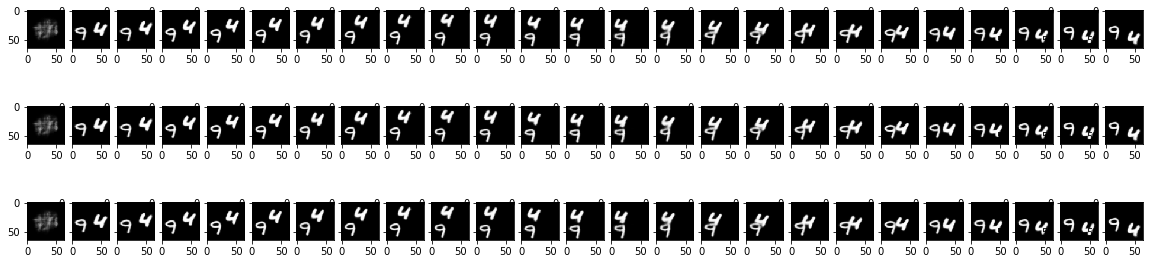

In [21]:
f, axs = plt.subplots(3, len(x))
for i in range(len(x)):
    img_gt = transforms.ToPILImage()(x_pred_recon[i][0].cpu())
    img_pred = transforms.ToPILImage()(x_pred_recon_diffZ[i][0].cpu())
    img_recon = transforms.ToPILImage()(x_pred_recon_zeroZ[i][0].cpu())
    axs[0][i].imshow(img_gt)
    axs[1][i].imshow(img_pred)
    axs[2][i].imshow(img_recon)
f.savefig('compare_diffZ.jpg', dpi=300)

# influence of hiddenstate

In [22]:
## Forward function for decoder part in pose branch
def forward_pose_decoder_branch_zero_hidden(vec_p_seq, vec_p_global):
    """
    Input: pose vector sequence, global pose vector
    Return: resonstructed pose vector sequence
    """
    vec_in_seq = []
    for i in range(len(vec_p_seq)):
        if i > 0:
            vec_in = vec_p_seq[i - 1]
        else:
            vec_in = torch.zeros_like(vec_p_seq[0])
        vec_in_seq.append(torch.cat([vec_p_global, vec_in], 1))
    
    vec_p_recon_seq = []
    for vec_in in vec_in_seq:
        vec_p_recon_seq.append(decoder_lstm([vec_in])[0][0])
    return vec_p_recon_seq

In [23]:
with torch.no_grad():
    vec_p_recon_zeroH = forward_pose_decoder_branch_zero_hidden(vec_p_seq, vec_p_global)
    x_pred_recon_zeroH = forward_decoder(vec_p_recon_zeroH, vec_c_global, skip)

In [24]:
l2_zeroH = []
for recon_zeroH, recon in zip(x_pred_recon_zeroH, x_pred_recon):
    l2_zeroH.append(F.mse_loss(recon_zeroH, recon).item())
l2_zeroH

[8.30220088640296e-14,
 0.025254573673009872,
 0.028684625402092934,
 0.030087420716881752,
 0.03369099646806717,
 0.03660169988870621,
 0.0383734330534935,
 0.03826354071497917,
 0.038527268916368484,
 0.03970920294523239,
 0.03989209607243538,
 0.03979385644197464,
 0.03856294974684715,
 0.03792320191860199,
 0.037303462624549866,
 0.03759222477674484,
 0.035311177372932434,
 0.03479670733213425,
 0.03394463658332825,
 0.035461921244859695,
 0.03598705306649208,
 0.03598383814096451,
 0.03603460639715195,
 0.036863062530756,
 0.037095338106155396]

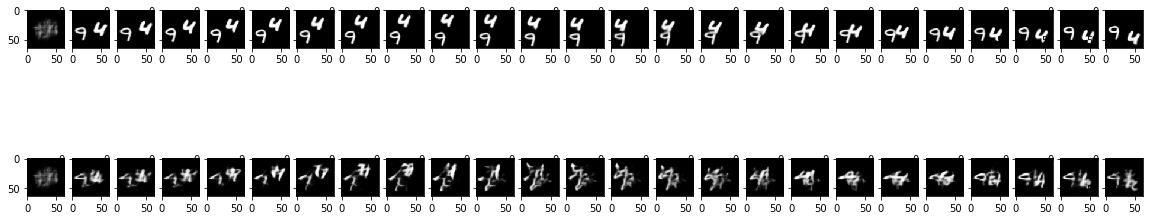

In [25]:
f, axs = plt.subplots(2, len(x))
for i in range(len(x)):
    img_recon = transforms.ToPILImage()(x_pred_recon[i][0].cpu())
    img_recon_zeroH = transforms.ToPILImage()(x_pred_recon_zeroH[i][0].cpu())
    axs[0][i].imshow(img_recon)
    axs[1][i].imshow(img_recon_zeroH)
f.savefig('compare_zeroH.jpg', dpi=300)

# influence of different input of decoder LSTM

In [26]:
# get next batch
y = next(testing_batch_generator)

In [27]:
with torch.no_grad():
    _, vec_c_global_y, skip_y = forward_content_branch(y[:opt.n_past])
    vec_p_seq_y_Cy, _, _, _ = forward_pose_encoder_branch(y, vec_c_global_y)
    vec_p_seq_y_Cx, _, _, _ = forward_pose_encoder_branch(y, vec_c_global)

In [28]:
## Forward function for decoder part in pose branch
def forward_pose_decoder_branch_zero_input(vec_p_seq, vec_p_global):
    """
    Input: pose vector sequence, global pose vector
    Return: resonstructed pose vector sequence
    """
    vec_in_seq = []
    for i in range(len(vec_p_seq)):
        if i > 0:
            vec_in = vec_p_seq[i - 1]
        else:
            vec_in = torch.zeros_like(vec_p_seq[0])
        vec_in_seq.append(torch.cat([vec_p_global, vec_in], 1))
    
    hidden_list = [None]
    hidden = None
    for vec_in in vec_in_seq:
        _, hidden = decoder_lstm([vec_in], hidden=hidden)
        hidden_list.append(hidden)
    
    vec_p_recon_seq = []
    vec = torch.cat([vec_p_global, torch.zeros_like(vec_p_seq[0])], 1)
    for i in range(len(vec_p_seq)):
        vec_p_recon_seq.append(decoder_lstm([vec], hidden=hidden_list[i])[0][0])
    return vec_p_recon_seq

## Forward function for decoder part in pose branch
def forward_pose_decoder_branch_diff_input(vec_p_seq, vec_p_global, vec_p_seq_new):
    """
    Input: pose vector sequence, global pose vector
    Return: resonstructed pose vector sequence
    """
    vec_in_seq = []
    for i in range(len(vec_p_seq)):
        if i > 0:
            vec_in = vec_p_seq[i - 1]
        else:
            vec_in = torch.zeros_like(vec_p_seq[0])
        vec_in_seq.append(torch.cat([vec_p_global, vec_in], 1))
    
    hidden_list = [None]
    hidden = None
    for vec_in in vec_in_seq:
        _, hidden = decoder_lstm([vec_in], hidden=hidden)
        hidden_list.append(hidden)
        
    vec_p_recon_seq = []
    for i in range(len(vec_p_seq_new)):
        if i > 0:
            vec_in = vec_p_seq_new[i - 1]
        else:
            vec_in = torch.zeros_like(vec_p_seq_new[0])
        vec = torch.cat([vec_p_global, vec_in], 1)
        vec_p_recon_seq.append(decoder_lstm([vec], hidden=hidden_list[i])[0][0])
    return vec_p_recon_seq

In [29]:
with torch.no_grad():
    vec_p_recon_zeroI = forward_pose_decoder_branch_zero_input(vec_p_seq, vec_p_global)
    vec_p_recon_diffI_Ey = forward_pose_decoder_branch_diff_input(vec_p_seq, vec_p_global, vec_p_seq_y_Cy)
    vec_p_recon_diffI_Ex = forward_pose_decoder_branch_diff_input(vec_p_seq, vec_p_global, vec_p_seq_y_Cx)
    
    x_pred_recon_zeroI = forward_decoder(vec_p_recon_zeroI, vec_c_global, skip)
    x_pred_recon_diffI_Ey_Dy = forward_decoder(vec_p_recon_diffI_Ey, vec_c_global_y, skip_y)
    x_pred_recon_diffI_Ex_Dx = forward_decoder(vec_p_recon_diffI_Ex, vec_c_global, skip)
    x_pred_recon_diffI_Ey_Dx = forward_decoder(vec_p_recon_diffI_Ey, vec_c_global, skip)

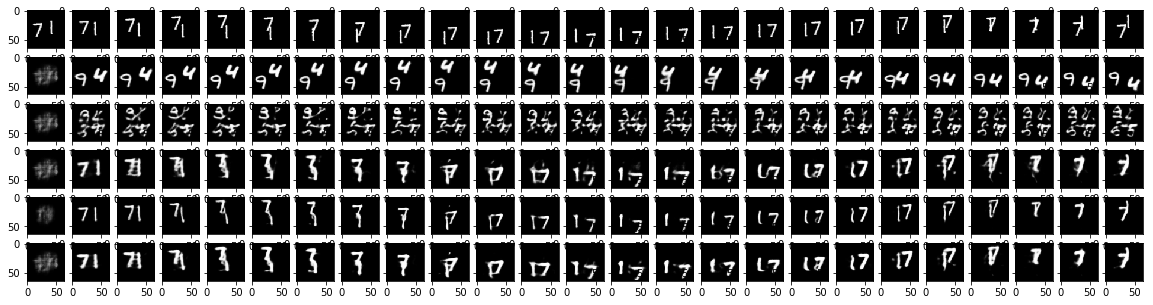

In [30]:
f, axs = plt.subplots(6, len(x))
for i in range(len(x)):
    img_y = transforms.ToPILImage()(y[i][0].cpu())
    img_recon = transforms.ToPILImage()(x_pred_recon[i][0].cpu())
    img_recon_zeroI = transforms.ToPILImage()(x_pred_recon_zeroI[i][0].cpu())
    img_recon_diffI_Ex_Dx = transforms.ToPILImage()(x_pred_recon_diffI_Ex_Dx[i][0].cpu())
    img_recon_diffI_Ey_Dy = transforms.ToPILImage()(x_pred_recon_diffI_Ey_Dy[i][0].cpu())
    img_recon_diffI_Ey_Dx = transforms.ToPILImage()(x_pred_recon_diffI_Ey_Dx[i][0].cpu())
    axs[0][i].imshow(img_y)
    axs[1][i].imshow(img_recon)
    axs[2][i].imshow(img_recon_zeroI)
    axs[3][i].imshow(img_recon_diffI_Ex_Dx)
    axs[4][i].imshow(img_recon_diffI_Ey_Dy)
    axs[5][i].imshow(img_recon_diffI_Ey_Dx)
f.savefig('compare_diffI.jpg', dpi=300)